In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
#%precision %.2f

import re
import seaborn as sns

# Importing required libraries
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Embedding

from keras.layers import Dense, Input

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import  Adam

from keras import regularizers

# gensim
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors


[nltk_data] Downloading package stopwords to C:\Users\User-
[nltk_data]     Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Null values in train.csv
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


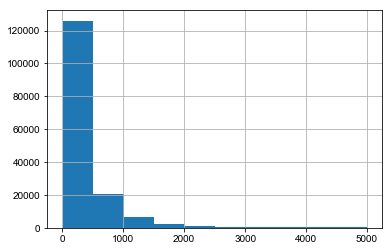

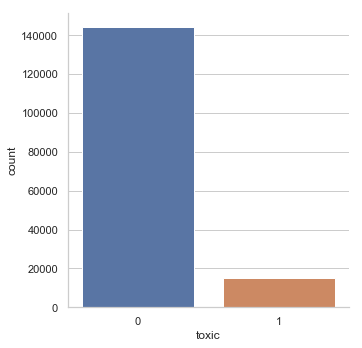

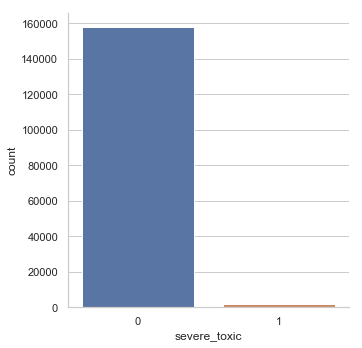

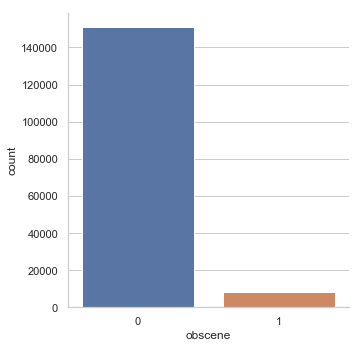

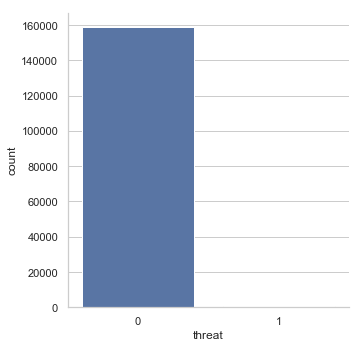

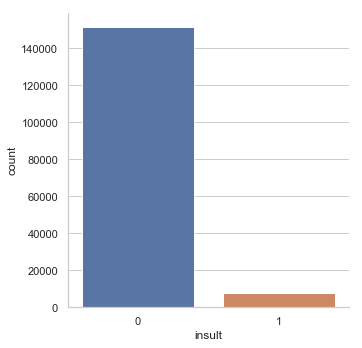

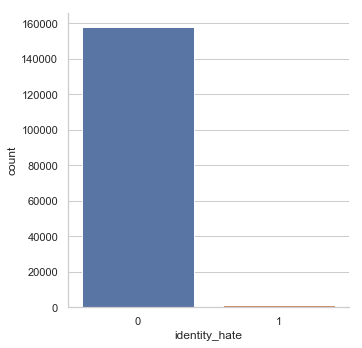

In [3]:
def cleantxt(txt):
    """
    Cleans the string passed. Cleaning Includes-
    1. remove special characters/symbols
    2. convert text to lower-case
    3. retain only alphabets
    4. remove words less than 3 characters
    5. remove stop-words
    """  
    # collecting english stop words from nltk-library
    stpw = stopwords.words('english')
    
    # Adding custom stop-words
    stpw.extend(['www','http','utc'])
    stpw = set(stpw)
    
    # using regex to clean the text
    txt = re.sub(r"\n", " ", txt)
    txt = re.sub("[\<\[].*?[\>\]]", " ", txt)
    txt = txt.lower()
    txt = re.sub(r"[^a-z ]", " ", txt)
    txt = re.sub(r"\b\w{1,3}\b", " ",txt)
    txt = " ".join([x for x in txt.split() if x not in stpw])
    return txt


def load_data():
    """
    Loads data and returns train, val, and test splits
    """
    # Load the train dataset
    df = pd.read_csv("data.csv")
    print('Null values in train.csv')
    print(df.isnull().sum())
    
    lens = df.comment_text.str.len()
    lens.mean(), lens.std(), lens.max()
    lens.hist();
    
    
    sns.set(style="whitegrid")
    sns.catplot(x='toxic',kind='count',data=df,orient="h")
    sns.catplot(x='severe_toxic',kind='count',data=df,orient="h")
    sns.catplot(x='obscene',kind='count',data=df,orient="h")
    sns.catplot(x='threat',kind='count',data=df,orient="h")
    sns.catplot(x='insult',kind='count',data=df,orient="h")
    sns.catplot(x='identity_hate',kind='count',data=df,orient="h")
    # Clean the text
    df['comment_text'] = df.comment_text.apply(lambda x : cleantxt(x))
    
    # separate explanatory and dependent variables
    X = df.iloc[:,1]
    y = df.iloc[:,[2,4,6]]

    # split for cross-validation (train-60%, validation 20% and test 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = load_data()

In [4]:
bad_words = pd.read_csv("bad_words.csv")
bad_words =  list(bad_words.bad_words.values)


# Set Maximum number of words to be embedded
NUM_WORDS = 20000

# Define/Load Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

# Fit the function on the text
tokenizer.fit_on_texts(X_train)

# Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


# size of bad words
num_badwords = len(bad_words)
num_badwords


# Adding list of bad words to tokanizer
n = 0
temp_bw = bad_words
for word, i in word_index.items():
    if word in bad_words:
        temp_bw.remove(word)
        n = n+1
    if i > (NUM_WORDS-num_badwords+n):
        for bw in temp_bw:
            tokenizer.word_index[bw] = i
            i=i+1
        break           
    
# Convert train and val to sequence
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid=tokenizer.texts_to_sequences(X_val)

# Limit size of train/val to 50 and pad the sequence
X_train = pad_sequences(sequences_train,maxlen=100)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])

# Convert target to array
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

# Printing shape
print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Found 119054 unique tokens.
Shape of X train and X validation tensor: (95742, 100) (31915, 100)
Shape of label train and validation tensor: (95742, 3) (31915, 3)


In [5]:
word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz",binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))


for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        if word in bad_words:
            vec = word_vectors['fuck']
        embedding_matrix[i]=vec
        
del(word_vectors)

# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=X_train.shape[1],
                            trainable=True)
del(embedding_matrix)

C:\Users\User-Pc\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [6]:
from keras import backend as K
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


sequence_length = X_train.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=3, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

# Compiling Model using optimizer
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=[f1_m])

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_adam = model.fit(X_train, y_train, batch_size=400, epochs=20, verbose=2, validation_data=(X_val, y_val),
         callbacks=callbacks)  # starts training


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 95742 samples, validate on 31915 samples
Epoch 1/20
 - 529s - loss: 0.2263 - f1_m: 0.3774 - val_loss: 0.1426 - val_f1_m: 0.7086
Epoch 2/20
 - 513s - loss: 0.1298 - f1_m: 0.7012 - val_loss: 0.1208 - val_f1_m: 0.6832
Epoch 3/20
 - 517s - loss: 0.1128 - f1_m: 0.7224 - val_loss: 0.1169 - val_f1_m: 0.7197
Epoch 4/20
 - 512s - loss: 0.1058 - f1_m: 0.7357 - val_loss: 0.1152 - val_f1_m: 0.7194
Epoch 5/20
 - 516s - loss: 0.1002 - f1_m: 0.7498 - val_loss: 0.1121 - val_f1_m: 0.7126
Epoch 6/20
 - 510s - loss: 0.0951 - f1_m: 0.7656 - val_loss: 0.1178 - val_f1_m: 0.6825


In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 98, 1, 100)   90100       reshape_1[0][0]                  
____________________________________________________________________________________________

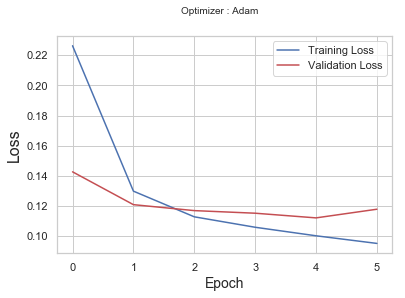

In [9]:
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(hist_adam.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adam.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [8]:
sequences_test=tokenizer.texts_to_sequences(X_test)
X_test2 = pad_sequences(sequences_test,maxlen=X_train.shape[1])
col = ['toxic', 'obscene', 'insult']

# Predict on test datasets

pred_test = model.predict(X_test2)


f1 = 0
pred_test=np.round(pred_test)
for i in range(0,3):
    actual_vaue = y_test.iloc[:,i]
    pred_test_col = pred_test[:,i].astype(int)
    f1 = f1 + f1_score(actual_vaue, pred_test_col)
    
print("Average Test F1 Score:",(f1/3)*100)

Average Test F1 Score: 68.35796702949723


In [9]:
# serialize model to JSON
model_json = model.to_json()
with open("model_gru.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_gru.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
t="kill you dickhead"
text =[t]
sequences_text = tokenizer.texts_to_sequences(text)
text = pad_sequences(sequences_text,maxlen=X_train.shape[1])
prediction = model.predict(text)
print(prediction)

[[0.98425275 0.9049632  0.81351775]]
